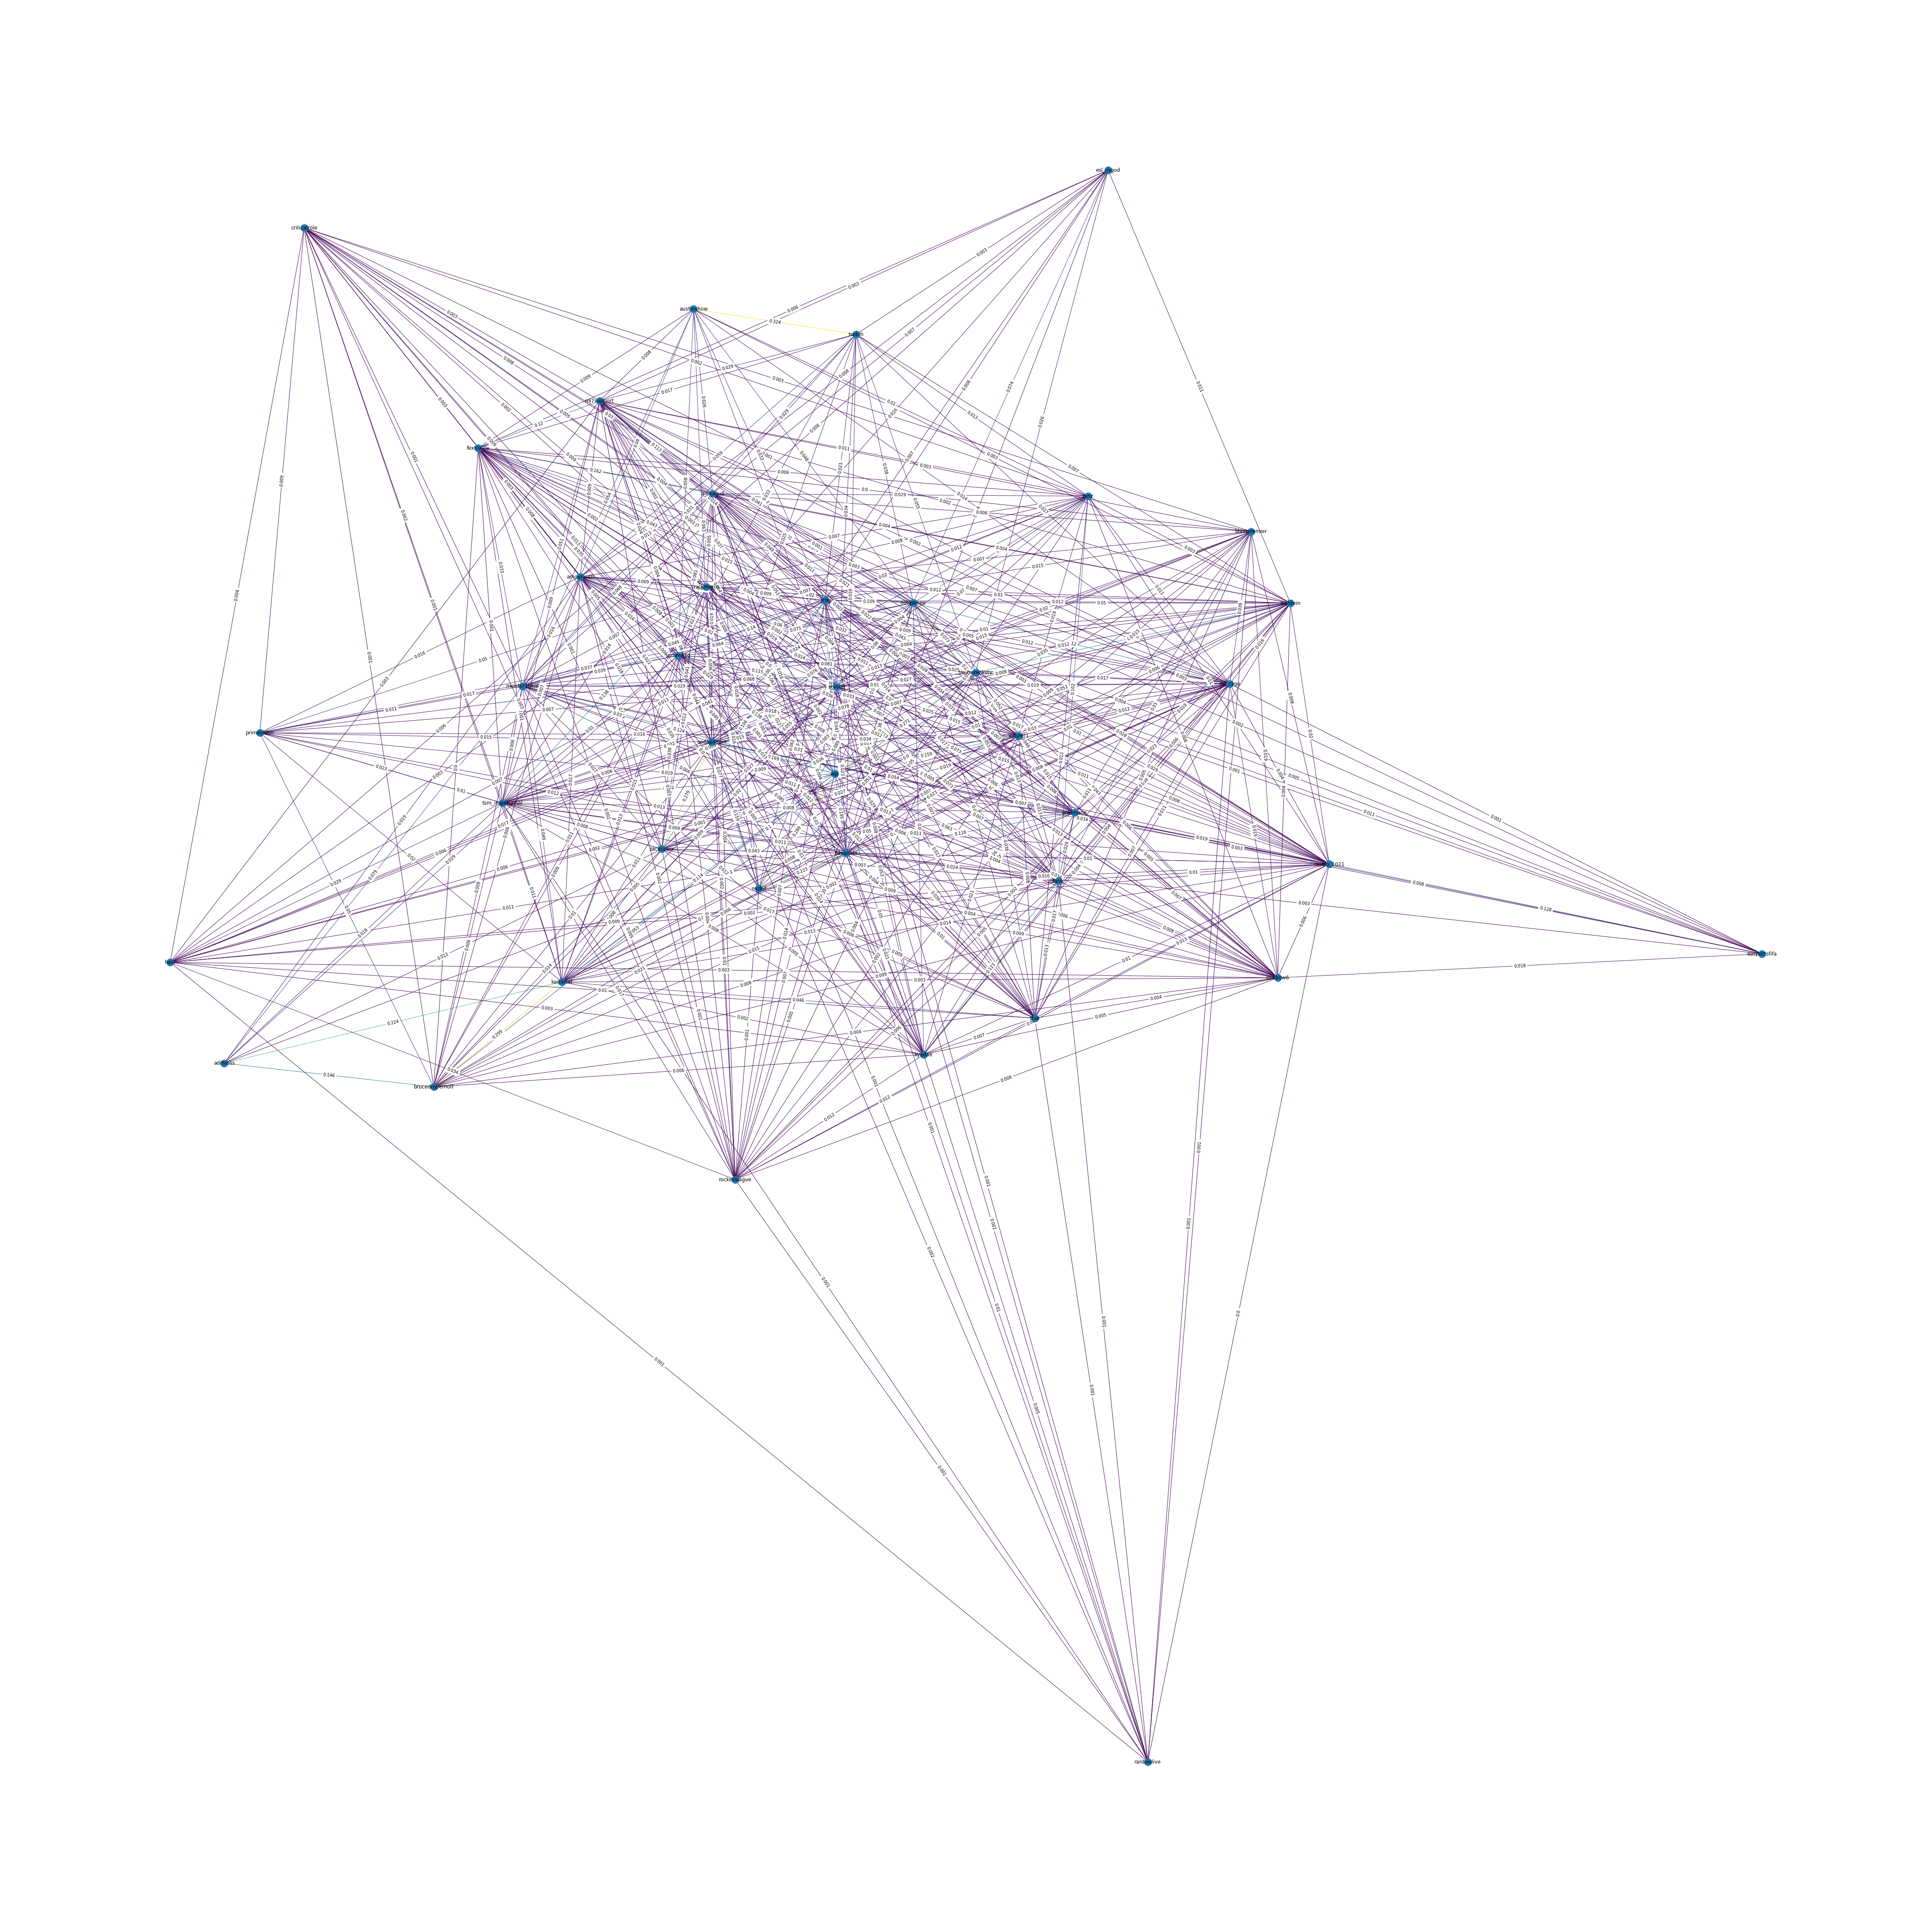

In [149]:
import psycopg2
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import math
import operator
import itertools

warnings.simplefilter(action='ignore', category=UserWarning)

# This changes on reboot -_-
wsl_ip = "172.23.211.95"

# Database connection
conn = psycopg2.connect(host=wsl_ip, port = 5432, database="postgres", user="postgres", password="postgres")

# Global average chatters
average_chatters = dict()
    
def getListOfChannels(limit):
    tables = pd.io.sql.read_sql_query("SELECT * FROM information_schema.tables WHERE table_schema LIKE '%public%'", conn)['table_name']
    for table in tables:
        if table in ['iterations','streams','users']:
            continue
        average_chatters[table] = pd.io.sql.read_sql_query(f"SELECT ROUND(AVG(total_chatters), 0) as avg_total FROM {table}", conn)['avg_total'][0]
    return dict(list(dict(sorted(average_chatters.items(), key=operator.itemgetter(1),reverse=True)).items())[0:limit])
        
def buildNetwork(channels):
    graph = nx.Graph()
    edge_list = dict()
    for channel in channels:
        graph.add_node(channel)
    
    # Initial read, insertion of edges, weights/chatter count
    for channel in channels:
        df = pd.io.sql.read_sql_query(f"SELECT channel_name, ROUND(AVG(overlap_count), 0) as avg_overlap FROM {channel} GROUP BY channel_name", conn)
        df = df[df.channel_name.isin(channels)]
        for row in df.iterrows():
            if (row[1]['channel_name'], channel) in edge_list.keys():
                entry = edge_list[(row[1]['channel_name'], channel)]
                edge_list[(row[1]['channel_name'], channel)] = (entry + row[1]['avg_overlap']) / 2.0 # divide by 2?
            else:
                edge_list[(channel, row[1]['channel_name'])] = row[1]['avg_overlap']
    
    # TODO: clustering
    
    # Add edges
    for key in edge_list.keys():
        chatter_count = (average_chatters[key[0]] if average_chatters[key[0]] < average_chatters[key[1]] else average_chatters[key[1]])
        edge_list[key] = round(edge_list[key] / chatter_count, 3)
        graph.add_edge(key[0], key[1], weight=edge_list[key])
        
    # Draw graph
    plt.figure(3,figsize=(64, 64)) 
    pos=nx.spring_layout(graph,center=(6,6))
    nx.draw(graph,pos,with_labels=True,edge_color=edge_list.values(), cmap=plt.cm.jet)
    labels = nx.get_edge_attributes(graph,'weight')
    nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)
    plt.show()

# Parse as Pandas dataframe

#df = fetchDataFrame("xqc")
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    channels = getListOfChannels(40)
    #print(channels)
    #channels = ['xqc', 'atrioc', 'nyanners', 'moistcr1tikal', 'moonmoon', 'northernlion', 'penta', 'ironmouse', 'adinross', 'kaicenat']
    buildNetwork(channels)
    

In [ ]:
def fetchDataFrameWithCategories(channel_name):
    #query = f"SELECT {channel_name}.*, streams.category_name FROM {channel_name} INNER JOIN streams ON ({channel_name}.iteration=streams.iteration AND streams.channel_name LIKE '%{channel_name}%')"
    df = pd.io.sql.read_sql_query(f"SELECT * FROM {channel_name}", conn)
    df_category = pd.io.sql.read_sql_query(f"SELECT iteration, category_name FROM streams WHERE channel_name LIKE '%xqc%'", conn)
    category_col = []
    
    for df_row in df.iterrows():
        iteration = df_row[1]['iteration']
        categories = []
        for cat_row in df_category.iterrows():
            if iteration-24 <= cat_row[1]['iteration'] <= iteration+24:
                if not cat_row[1]['category_name'] in categories:
                    categories.append(cat_row[1]['category_name'])
                
        #print(','.join(categories))
        category_col.append(','.join(categories))
    df['channel_categories'] = category_col
    return df

# https://stackoverflow.com/questions/16417916/normalizing-dictionary-values
def really_safe_normalise_in_place(d):
    factor=1.0/math.fsum(d.values())
    for k in d:
        d[k] = d[k]*factor
    key_for_max = max(d.items(), key=operator.itemgetter(1))[0]
    diff = 1.0 - math.fsum(d.values())
    #print "discrepancy = " + str(diff)
    d[key_for_max] += diff